# MedSAM automatic point prompt all data

## Load packages

In [1]:
import nibabel as nib
from segment_anything import sam_model_registry
from os.path import join, isfile, basename
from os import getcwd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from torch.nn import functional as F
import cv2
import torch
import numpy as np
import gc
import SimpleITK as sitk
import numpy as np
import glob
import os
from matplotlib import pyplot as plt
from skimage import io, transform
#import tensorflow as tf
#from tensorflow.keras.metrics import MeanIoU
from utils.SurfaceDice import compute_dice_coefficient

## Load model

In [31]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

medsam_ckpt_path = "D:\Stage\MedSAM\medsam_point_prompt_flare22.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=medsam_ckpt_path)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


## Load data

In [2]:
image_folder_path = "D:/Stage/Pancreas_dataset/t2/imagesTr"
mask_path = "D:/Stage/Pancreas_dataset/t2/labelsTr"
modality='MRI'

# Use glob to find all .nii files in the folder
nii_files = glob.glob(f"{image_folder_path}/*.nii/*.nii")
mask_files = glob.glob(f"{mask_path}/*.nii/*.nii")

# Create a dictionary to map image file names (without path or extension) to the full paths
image_dict = {os.path.basename(nii_file).split('.')[0]: nii_file for nii_file in nii_files}
mask_dict = {os.path.basename(mask_file).split('.')[0]: mask_file for mask_file in mask_files}


 ## Some functions

In [3]:
def  normalization(modality, image_data):
    """ Normalizes CT or MRI data """
    #%%Normalization
    if modality =='CT':
        lower_bound = WINDOW_LEVEL - WINDOW_WIDTH / 2
        upper_bound = WINDOW_LEVEL + WINDOW_WIDTH / 2
        image_data_pre = np.clip(image_data, lower_bound, upper_bound)
        image_data_pre = (
                (image_data_pre - np.min(image_data_pre))
                / (np.max(image_data_pre) - np.min(image_data_pre))
                * 255.0)
    else:
        lower_bound, upper_bound = np.percentile(
                        image_data[image_data > 0], 0.5
                    ), np.percentile(image_data[image_data > 0], 99.5)
        image_data_pre = np.clip(image_data, lower_bound, upper_bound)
        image_data_pre = (
                        (image_data_pre - np.min(image_data_pre))
                        / (np.max(image_data_pre) - np.min(image_data_pre))
                        * 255.0
                    )           
        image_data_pre[image_data == 0] = 0

    image_data_pre = np.uint8(image_data_pre)

    return image_data_pre

In [4]:
def reshape(image_data_pre):
    """ Turn gray image into RGB image """
    #%% Reshape
    if len(image_data_pre.shape) == 2:
        img_3c = np.repeat(image_data_pre[:, :, None], 3, axis=-1)
    else:
        img_3c = image_data_pre
    H, W, _ = img_3c.shape

    return img_3c, H, W

def resize(img_3c):
    """ Resizes image of 3 channels into 1024x1024 pixels"""
    img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True, mode= 'constant').astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device))
    return img_1024, img_1024_tensor

def resize_mask(mask):
    """ Resizes mask into mask of 1024x1024 pixels"""
    mask_1024 = transform.resize(
    mask, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True, mode= 'constant').astype(np.uint8)
    mask_1024 = (mask_1024 - mask_1024.min()) / np.clip(mask_1024.max() - mask_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    return mask_1024

In [5]:
def sample_random_points(mask, num_points=10):
    """
    Samples random points from the foreground of a binary mask.
    
    Parameters:
    - mask (np.array): A binary 2D mask (foreground == 1, background == 0)
    - num_points (int): Number of points to sample
    
    Returns:
    - sampled_points (np.array): Array of shape (num_points, 2) containing the sampled coordinates
    """
    # Get the indices of all non-zero points (foreground)
    foreground_indices = np.argwhere(mask == 1)  # returns coordinates of all points where mask == 1
    
    if len(foreground_indices) == 0:
        raise ValueError("No foreground points found in the mask.")
    
    # Randomly sample points from the foreground indices
    sampled_indices = np.random.choice(len(foreground_indices), size=num_points, replace=False)
    sampled_points = foreground_indices[sampled_indices]

    sampled_points_xy = np.array(sampled_points[:, [1, 0]])  # Swap columns
    
    
    return sampled_points

def sample_stratified_points(mask, num_points=10, grid_size=4):
    """
    Samples evenly distributed points from the foreground of a binary mask using stratified sampling.
    
    Parameters:
    - mask (np.array): A binary 2D mask (foreground == 1, background == 0)
    - num_points (int): Total number of points to sample
    - grid_size (int): Number of grid divisions along each axis (total regions = grid_size^2)
    
    Returns:
    - sampled_points (np.array): Array of shape (num_points, 2) containing the sampled coordinates
    """
    # Get the indices of all non-zero points (foreground)
    foreground_indices = np.argwhere(mask == 1)  # returns coordinates of all points where mask == 1
    
    if len(foreground_indices) == 0:
        raise ValueError("No foreground points found in the mask.")
    
    h, w = mask.shape
    points_per_region = max(1, num_points // (grid_size ** 2))
    sampled_points = []

    # Create grid boundaries
    x_bins = np.linspace(0, w, grid_size + 1, dtype=int)
    y_bins = np.linspace(0, h, grid_size + 1, dtype=int)
    
    for i in range(grid_size):
        for j in range(grid_size):
            # Find points in the current grid region
            region_points = foreground_indices[
                (foreground_indices[:, 1] >= x_bins[i]) & (foreground_indices[:, 1] < x_bins[i + 1]) &
                (foreground_indices[:, 0] >= y_bins[j]) & (foreground_indices[:, 0] < y_bins[j + 1])
            ]
            # If there are points in the region, sample from them
            if len(region_points) > 0:
                sampled_indices = np.random.choice(len(region_points), min(points_per_region, len(region_points)), replace=False)
                sampled_points.extend(region_points[sampled_indices])

    sampled_points = np.array(sampled_points)
    
    # If we don't have enough points after stratified sampling, sample additional points randomly
    if len(sampled_points) < num_points:
        additional_points = np.random.choice(len(foreground_indices), num_points - len(sampled_points), replace=False)
        sampled_points = np.vstack((sampled_points, foreground_indices[additional_points]))

    sampled_points_xy = sampled_points[:, [1, 0]]  # Swap columns
    
    
    return sampled_points_xy[:num_points]

In [6]:
def save_seg(segmentation, image_path, slice_nr):
    """ Saves segmentation result in parent folder per slice"""
    parent_folder = os.path.dirname(image_path)
    # Create the output path inside the parent folder
    base_name = os.path.basename(image_path).split('.')[0]  # Get base name without extension
    out_path = os.path.join(parent_folder, f"{base_name}_slice_{slice_nr}_seg_result_medsam_pointprompt.png")

    #out_path_segs = f"{image_path.split('.')[0]}_slice_{slice_nr}_segs.png"
    cv2.imwrite(out_path, segmentation*255)

In [7]:
def show_mask(mask, ax, random_color=False, alpha=0.3):
    #mask_foreground = np.argwhere(mask == 1)
    #if random_color:
        #color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    #else:
        #color = np.array([30/255, 144/255, 255/255, 0.6])
    #h, w = mask_foreground.shape[-2:]
    #mask_image = mask_foreground.reshape(h, w, 1) * color.reshape(1, 1, -1)

     # Create a mask image with the same shape as the original image
    mask_image = np.zeros((*mask.shape, 3))  # Shape (height, width, 3) for RGB

    if random_color:
        color = np.random.random(3)  # Random RGB color
    else:
        color = np.array([30/255, 144/255, 255/255])  # Example fixed color (blue)

    # Apply the color to the mask where it's non-zero
    mask_image[mask == 1] = color  # Set color at mask positions

    ax.imshow(mask_image, alpha=alpha)

In [8]:
def show_points(coords, ax, marker_size=100):
    pos_points = coords
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1)

In [9]:
@torch.no_grad()
def medsam_inference(medsam_model, img_embed, point, H, W):

    coords_torch = torch.tensor(point, dtype=torch.float32).to(device)
    input_label = np.array([1]*len(point))
    labels_torch = torch.tensor(input_label, dtype=torch.long).to(device)
    point_prompt = (coords_torch, labels_torch)

    coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=(coords_torch, labels_torch),
        boxes=None,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [22]:
def calculate_iou(mask1, mask2):
    """
    Calculates the Intersection over Union (IoU) between two binary masks.

    Args:
    - mask1: 2D binary numpy array (e.g., ground truth mask).
    - mask2: 2D binary numpy array (e.g., predicted mask).

    Returns:
    - iou: Intersection over Union as a float.
    """
    # Ensure the masks are boolean (0 and 1)
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    
    # Calculate intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    
    if union == 0:
        return np.NaN  # Avoid division by zero, return NaN if both masks are empty
    
    iou = intersection / union
    return iou

## Process data

In [11]:
# Loop over images

for nii_file in nii_files:
    # Extract the image name (without extension) and remove '_0000' suffix if present
    image_name = os.path.basename(nii_file).split('.')[0].replace('_0000', '')
    
    if image_name in mask_dict:  # Check if there is a matching mask file
        mask_path = mask_dict[image_name]


        # Load the image and corresponding mask
        image = nib.load(nii_file).get_fdata()
        mask = nib.load(mask_path).get_fdata()


        for slice_nr in range(image.shape[2]):
            image_data = image[:,:,slice_nr]
            mask_data = mask[:,:,slice_nr]

            if np.sum(mask_data == 1) >= 100:
                print(f"Processing slice {slice_nr} of image {image_name}")

                #Preprocessing    
                image_data_pre = normalization(modality, image_data)
                img_3c, H, W = reshape(image_data_pre)

                img_1024, img_1024_tensor = resize(img_3c)

                mask_1024 = resize_mask(mask_data)

                points = sample_stratified_points(mask_1024, num_points=4)
                #plt.figure()
                #plt.gca().cla()
                #plt.imshow(mask_1024, cmap='gray')
                #show_points(points, plt.gca())
                #plt.axis('off')
                #plt.show()

                
                with torch.no_grad():
                    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)


                medsam_seg = medsam_inference(medsam_model, image_embedding, points, H, W)
                if np.any(medsam_seg != 0):
                    print("The mask contains non-zero values.")
                    save_seg(medsam_seg, mask_path, slice_nr)
                    medsam_seg_resized = resize_mask(medsam_seg)

                    #plt.figure(figsize=(10,10))
                    #plt.imshow(img_1024)
                    #show_mask(medsam_seg_resized, plt.gca())
                    #plt.axis('off')
                    #plt.show() 
                else:
                    print("The mask does not contain any non-zero values.")
       
            else:
                print(f"Skipping slice {slice_nr} of image {image_name}: Not enough mask pixels")
    
    else:
            print(f"Warning: No corresponding mask found for {image_name}")

Skipping slice 0 of image AHN_0001: Not enough mask pixels
Skipping slice 1 of image AHN_0001: Not enough mask pixels
Skipping slice 2 of image AHN_0001: Not enough mask pixels
Skipping slice 3 of image AHN_0001: Not enough mask pixels
Skipping slice 4 of image AHN_0001: Not enough mask pixels
Skipping slice 5 of image AHN_0001: Not enough mask pixels
Skipping slice 6 of image AHN_0001: Not enough mask pixels
Skipping slice 7 of image AHN_0001: Not enough mask pixels
Skipping slice 8 of image AHN_0001: Not enough mask pixels
Skipping slice 9 of image AHN_0001: Not enough mask pixels
Skipping slice 10 of image AHN_0001: Not enough mask pixels
Skipping slice 11 of image AHN_0001: Not enough mask pixels
Processing slice 12 of image AHN_0001
The mask contains non-zero values.
Processing slice 13 of image AHN_0001
The mask contains non-zero values.
Processing slice 14 of image AHN_0001
The mask contains non-zero values.
Processing slice 15 of image AHN_0001
The mask contains non-zero values

Skipping slice 0 of image AHN_0001: Not enough mask pixels
Skipping slice 1 of image AHN_0001: Not enough mask pixels
Skipping slice 2 of image AHN_0001: Not enough mask pixels
Skipping slice 3 of image AHN_0001: Not enough mask pixels
Skipping slice 4 of image AHN_0001: Not enough mask pixels
Skipping slice 5 of image AHN_0001: Not enough mask pixels
Skipping slice 6 of image AHN_0001: Not enough mask pixels
Skipping slice 7 of image AHN_0001: Not enough mask pixels
Skipping slice 8 of image AHN_0001: Not enough mask pixels
Skipping slice 9 of image AHN_0001: Not enough mask pixels
Skipping slice 10 of image AHN_0001: Not enough mask pixels
Skipping slice 11 of image AHN_0001: Not enough mask pixels
Processing slice 12 of image AHN_0001
The mask contains non-zero values.


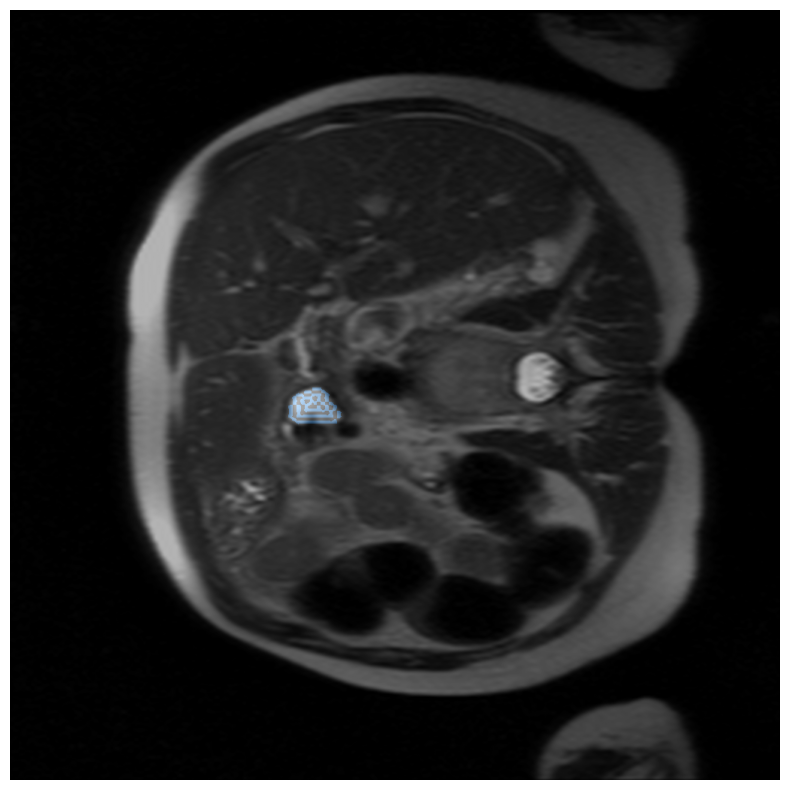

Processing slice 13 of image AHN_0001
The mask contains non-zero values.


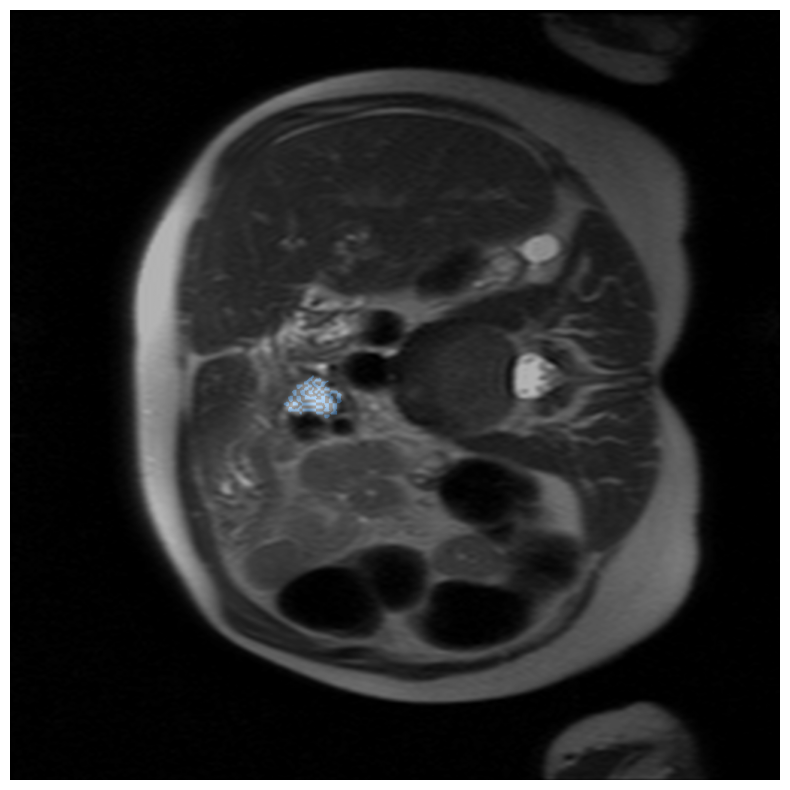

Processing slice 14 of image AHN_0001
The mask contains non-zero values.


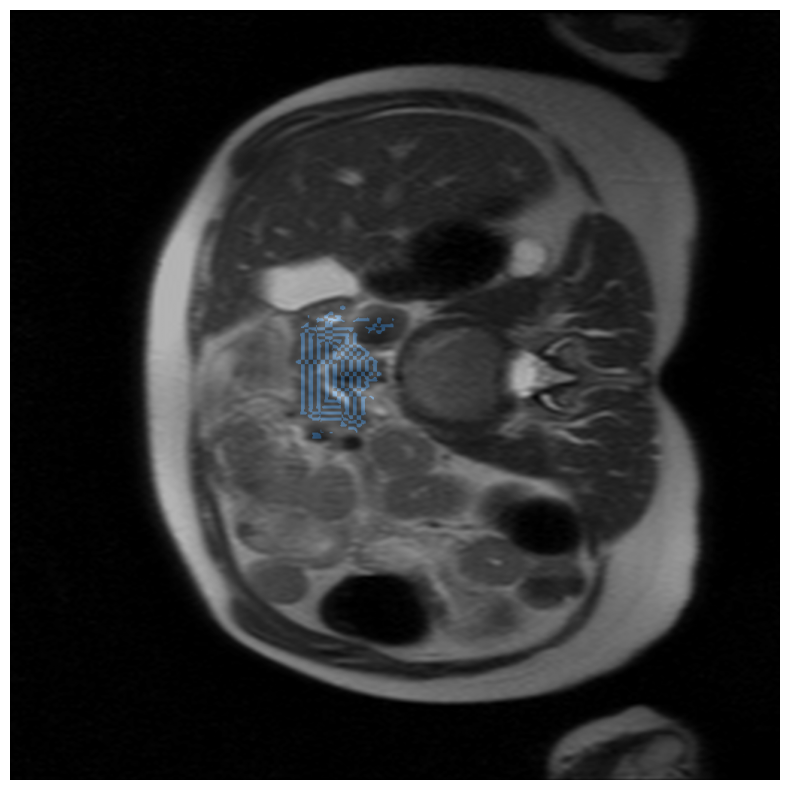

Processing slice 15 of image AHN_0001
The mask contains non-zero values.


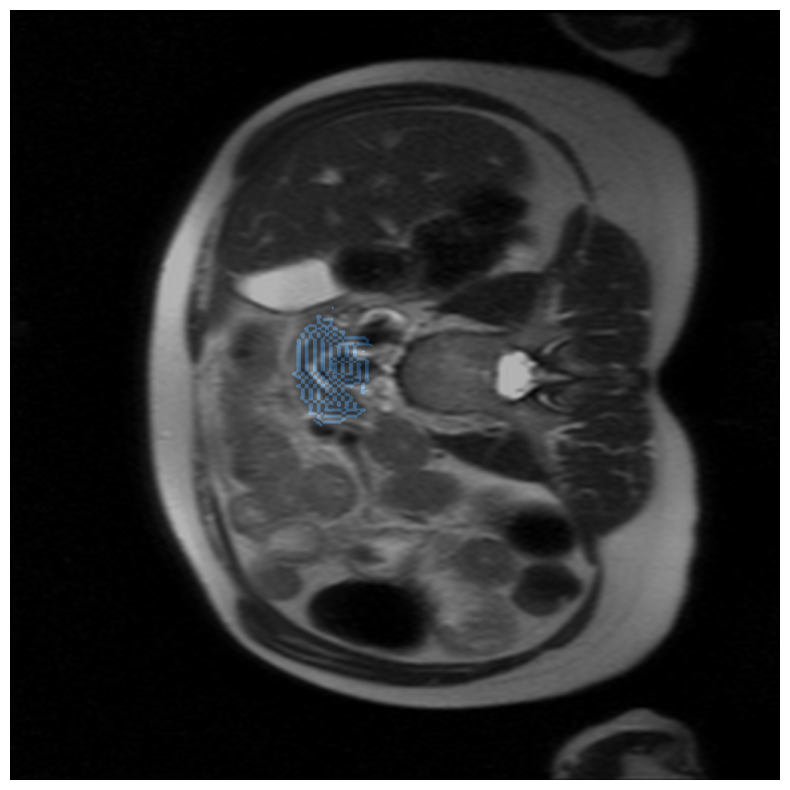

Processing slice 16 of image AHN_0001
The mask contains non-zero values.


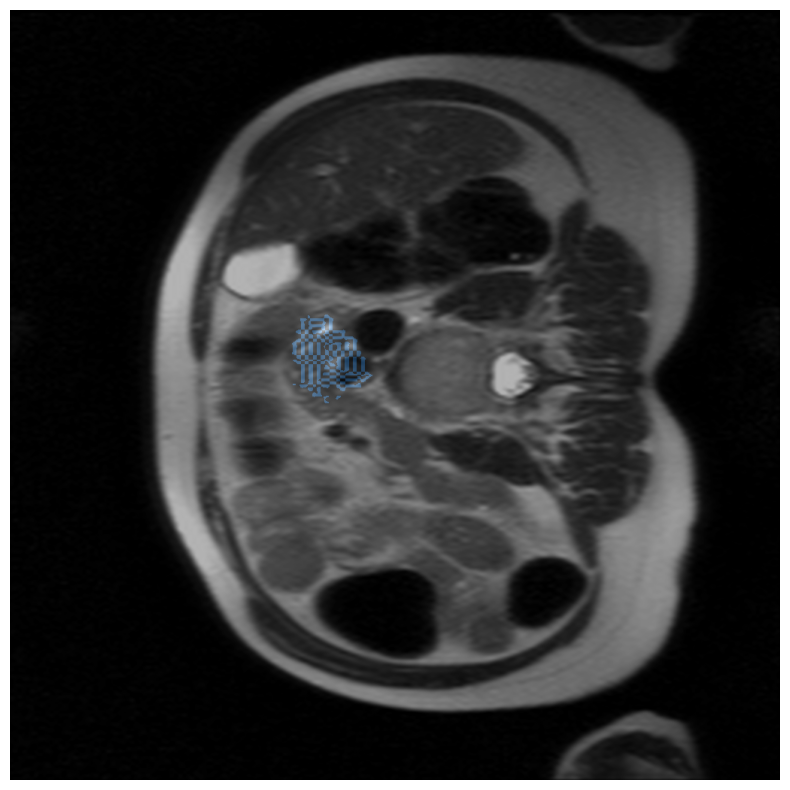

Processing slice 17 of image AHN_0001
The mask contains non-zero values.


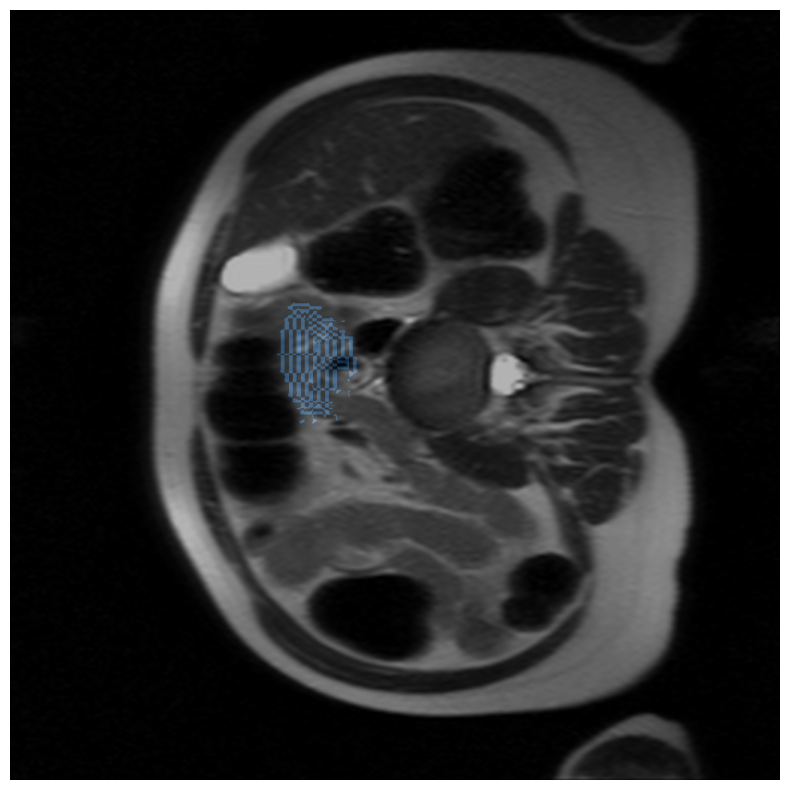

Processing slice 18 of image AHN_0001
The mask contains non-zero values.


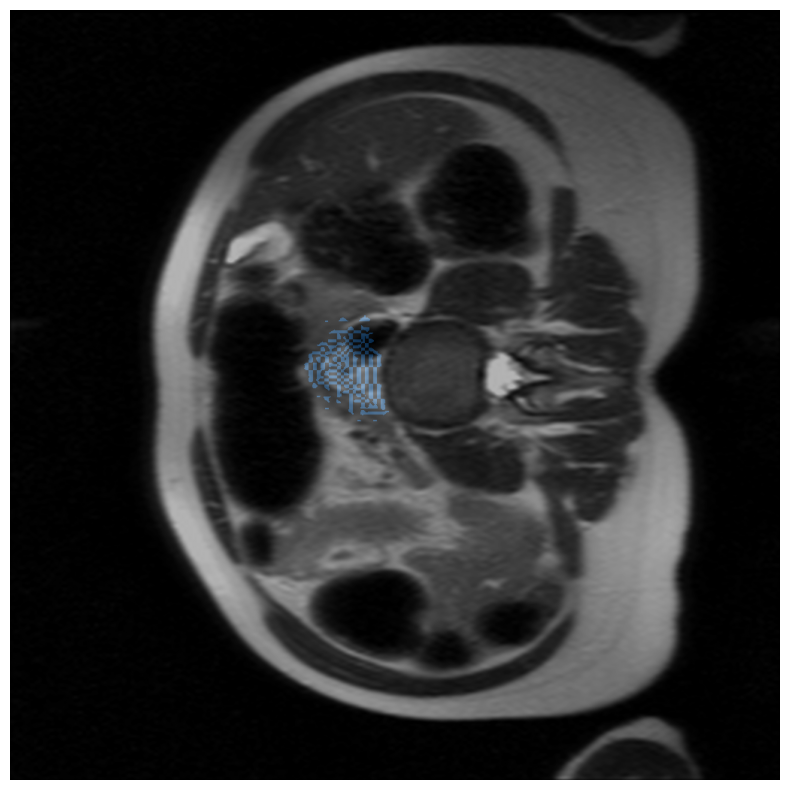

Processing slice 19 of image AHN_0001
The mask contains non-zero values.


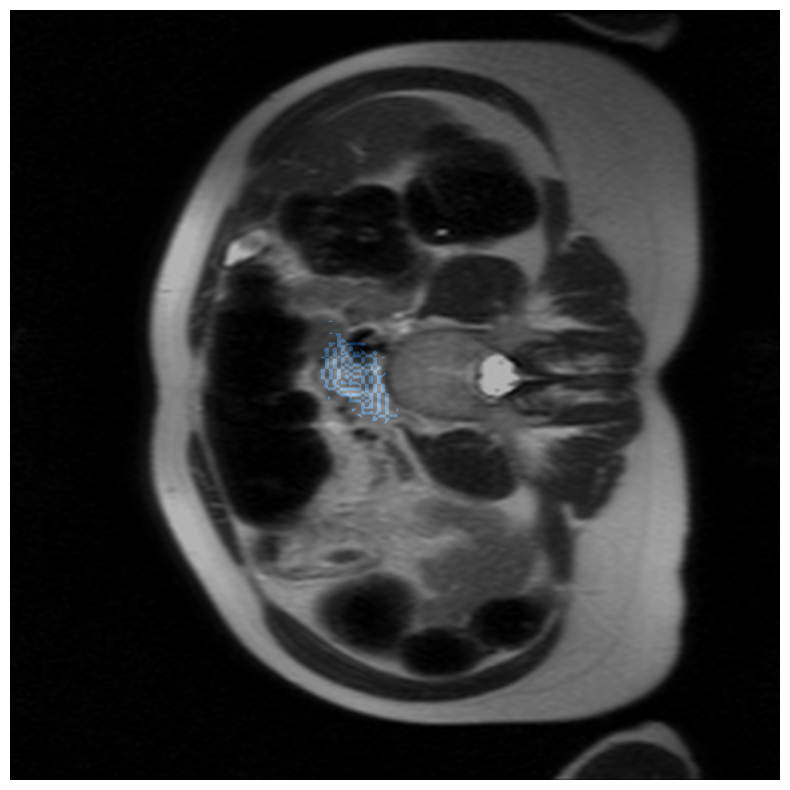

Skipping slice 20 of image AHN_0001: Not enough mask pixels
Skipping slice 21 of image AHN_0001: Not enough mask pixels
Skipping slice 22 of image AHN_0001: Not enough mask pixels
Skipping slice 23 of image AHN_0001: Not enough mask pixels
Skipping slice 24 of image AHN_0001: Not enough mask pixels
Skipping slice 25 of image AHN_0001: Not enough mask pixels


In [33]:
# Loop over images

for nii_file in nii_files[:1]:
    # Extract the image name (without extension) and remove '_0000' suffix if present
    image_name = os.path.basename(nii_file).split('.')[0].replace('_0000', '')
    
    if image_name in mask_dict:  # Check if there is a matching mask file
        mask_path = mask_dict[image_name]


        # Load the image and corresponding mask
        image = nib.load(nii_file).get_fdata()
        mask = nib.load(mask_path).get_fdata()


        for slice_nr in range(image.shape[2]):
            image_data = image[:,:,slice_nr]
            mask_data = mask[:,:,slice_nr]

            if np.sum(mask_data == 1) >= 100:
                print(f"Processing slice {slice_nr} of image {image_name}")

                #Preprocessing    
                image_data_pre = normalization(modality, image_data)
                img_3c, H, W = reshape(image_data_pre)

                img_1024, img_1024_tensor = resize(img_3c)

                mask_1024 = resize_mask(mask_data)

                points = sample_stratified_points(mask_1024, num_points=4)
                #plt.figure(figsize=(10,10)
                #plt.gca().cla()
                #plt.imshow(mask_1024, cmap='gray')
                #show_points(points, plt.gca())
                #plt.axis('off')
                #plt.show()

                
                with torch.no_grad():
                    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)


                medsam_seg = medsam_inference(medsam_model, image_embedding, points, H, W)
                if np.any(medsam_seg != 0):
                    print("The mask contains non-zero values.")
                    save_seg(medsam_seg, mask_path, slice_nr)
                    medsam_seg_resized = resize_mask(medsam_seg)

                    plt.figure(figsize=(10,10))
                    plt.imshow(img_1024)
                    show_mask(medsam_seg_resized, plt.gca())
                    plt.axis('off')
                    plt.show() 
                else:
                    print("The mask does not contain any non-zero values.")
       
            else:
                print(f"Skipping slice {slice_nr} of image {image_name}: Not enough mask pixels")
    
    else:
            print(f"Warning: No corresponding mask found for {image_name}")

## Evaluation

In [36]:
dice_coefficients = []
ious = []

for mask_file in mask_files:
    mask = nib.load(mask_file).get_fdata()
    mask_name = os.path.basename(mask_file).split('.')[0]
    parent_folder = os.path.dirname(mask_file)

    for slice_nr in range(mask.shape[2]):
        mask_data = mask[:,:,slice_nr]
        mask_gt = mask_data.astype(bool)  # Convert ground truth mask to boolean
       
        # Construct the filename for the segmentation result
        segmentation_file = os.path.join(parent_folder, f"{mask_name}_slice_{slice_nr}_seg_result_medsam_pointprompt.png")
    
        # Check if the file exists
        if os.path.isfile(segmentation_file):
            #print(f"File exists for slice {slice_nr}: {segmentation_file}")

            segmentation = cv2.imread(segmentation_file)
            mask_pred = (segmentation.sum(axis=-1) > 0).astype(bool)  # Convert to binary based on any non-zero value in the channels

            #plt.figure(figsize=(10,10))
            #plt.gca().cla()
            #plt.imshow(mask_gt)
            #show_mask(mask_pred, plt.gca())
            #plt.axis('off')
            #plt.show() 

            dice_coefficient = compute_dice_coefficient(mask_gt, mask_pred)
            dice_coefficients.append(dice_coefficient)

            iou = calculate_iou(mask_gt, mask_pred)
            ious.append(iou)

        else:
            #print(f"File does not exist for slice {slice_nr}.")
            continue
            

print(np.mean(dice_coefficients))
print(np.mean(ious))

0.3581652602867063
0.247534341893429
